In [1]:
%run pretrained-model.ipynb

CUDA Available:  True


In [3]:
import torch
import numpy as np
import random
from torchvision import datasets, transforms
from torch.autograd.functional import jacobian

In [4]:
def jsma_jacobian(model, X):
    f = lambda image: model(image).to(device)
    
    # output shape 10 x 784
    return jacobian(f, X).squeeze().reshape(-1,784)

In [5]:
def saliency_map(jacobian, target, increasing, search_space):
    """Compute saliency map of an image

    jacobian:     The jacobian matrix
    target:       The target label
    increasing:   Denote the use of incrementing or decrementing pixels method
    search_space: The image search space 
    
    return:       The saliency map
    """ 

    # The forward derivative of the target class
    target_grad = jacobian[target]  
    # The sum of forward derivative of all other classes
    others_grad = torch.sum(jacobian, dim=0) - target_grad  
    
    # Crossout pixels not in the search space
    target_grad *= search_space 
    others_grad *= search_space

    # Calculate sum of target forward derivative of any 2 features.
    alpha = target_grad.reshape(-1, 1, 784) + target_grad.reshape(-1, 784, 1)  
    # Calculate sum of other forward derivative of any 2 features.
    beta = others_grad.reshape(-1, 1, 784) + others_grad.reshape(-1, 784, 1)

    # Cross out entries that does not satisfy the condition (from formula 8 and 9)
    condition1 = alpha > 0.0 if increasing else alpha < 0.0
    condition2 = beta < 0.0 if increasing else beta > 0.0
    zero_mask = torch.ones(784, 784).fill_diagonal_(0).to(device)

    # Apply the condition to the saliency map
    mask = (condition1 * condition2) * zero_mask
    
    # Form the actuall map, entries are either invalid (crossed out) or equal alpha x beta
    saliency_map = alpha * torch.abs(beta) if increasing else torch.abs(alpha) * beta
    saliency_map *= mask # cross out invalid entries
    
    # get the two most significant pixels
    _, idx = torch.max(saliency_map.reshape(-1, 784 * 784), dim=1)
    
    p1 = torch.div(idx, 784, rounding_mode='floor')
    p2 = idx % 784
    
    return p1.item(), p2.item()

In [6]:
def jsma(image, target, step_size, max_iters, model):
    """Perform JSMA attack on an image

    image:     The input image X
    target:    The target label
    step_size: The perturbation size
    max_iters: The maximum itrations of the attack
    model:     The prediction model
    
    return:    The adversatial image X*
    """ 
        
    shape = image.shape
    image = torch.flatten(image) # Flatten the image to 1D for easier modification 
    
    increasing    = True if step_size > 0 else False
    search_domain = image < 1 if increasing else image > 0
    
    # Label predicted by the model
    prediction = torch.argmax(model(image.reshape(shape))).item()

    iter_ = 0
    while (iter_ < max_iters) and (prediction != target) and (search_domain.sum() != 0):
        # Calculate Jacobian matrix 
        jacobian = jsma_jacobian(model, image.reshape(shape))
        # Get the two most salient pixels
        p1, p2 = saliency_map(jacobian, target, increasing, search_domain)
        
        # Modify pixels, and clip the image
        image[p1] += step_size
        image[p2] += step_size
        image = torch.clamp(image, min=0.0, max=1.0)
        
        # Cross out modified pixels in the search space
        search_domain[p1] = 0
        search_domain[p2] = 0
        
        # Update the new label predicted by the model
        prediction = torch.argmax(model(image.reshape(shape))).item()

        iter_ += 1

    return image.reshape(shape)

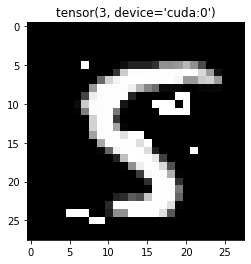

In [7]:
test_loader_iter = iter(test_loader)
input1 = next(test_loader_iter)

adv_image = jsma(image     = input1[0].to(device), 
                 target    = 3,  
                 step_size = 1, 
                 max_iters = 40,
                 model     = model).reshape([1,1,28,28])

import matplotlib.pyplot as plt

plt.title(torch.argmax(model(adv_image)))
plt.imshow(adv_image.squeeze().cpu(), cmap="gray")

In [8]:
correct = 0

for j in range(100):
    image, label = next(test_loader_iter)
    
    for target in range(10):
        # Can't target the actual label can we?
        if target == label.item():
            continue
        
        adv_image = jsma(image     = image.to(device), 
                         target    = target,  
                         step_size = 1, 
                         max_iters = 40,
                         model     = model).reshape([1,1,28,28])

        prediction = torch.argmax(model(adv_image)).item()
        
        # Correct if the prediction is the target label
        if prediction == target:
            correct += 1
    print(correct,'/', (j+1) * 9, correct * 100 / ((j+1) * 9))

9 / 9 100.0
18 / 18 100.0
27 / 27 100.0
36 / 36 100.0
45 / 45 100.0
54 / 54 100.0
63 / 63 100.0
72 / 72 100.0
81 / 81 100.0
90 / 90 100.0
99 / 99 100.0
107 / 108 99.07407407407408
116 / 117 99.14529914529915
125 / 126 99.2063492063492
132 / 135 97.77777777777777
140 / 144 97.22222222222223
149 / 153 97.38562091503267
158 / 162 97.53086419753086
167 / 171 97.6608187134503
176 / 180 97.77777777777777
185 / 189 97.88359788359789
194 / 198 97.97979797979798
203 / 207 98.06763285024155
212 / 216 98.14814814814815
221 / 225 98.22222222222223
230 / 234 98.2905982905983
239 / 243 98.35390946502058
248 / 252 98.41269841269842
257 / 261 98.46743295019157
266 / 270 98.51851851851852
275 / 279 98.5663082437276
284 / 288 98.61111111111111
293 / 297 98.65319865319866
302 / 306 98.69281045751634
311 / 315 98.73015873015873
320 / 324 98.76543209876543
329 / 333 98.7987987987988
338 / 342 98.83040935672514
347 / 351 98.86039886039886
356 / 360 98.88888888888889
365 / 369 98.9159891598916
374 / 378 98.9